In [1]:
%%capture
# Setup: Install packages we will need in this notebook
%pip uninstall pyfmrheo -y
%pip install git+https://github.com/jlopezalo/PyFMRheo.git
%pip install matplotlib

In [19]:
from pyfmreader import loadfile
from pyfmrheo.routines.HertzFit import doHertzFit
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# Define global parameters for plotting
plt.rcParams["figure.figsize"] = (10,5)

In [21]:
# Define path of file to process
file_path = r"../tests/testfiles/map-data-2022.10.29-12.27.34.564.jpk-force-map"

In [22]:
# Load File
file = loadfile(file_path)
filemetadata = file.filemetadata
print(filemetadata['file_type'])

jpk-force-map


In [23]:
# Get some of the file metadata
closed_loop = filemetadata['z_closed_loop']
file_deflection_sensitivity = filemetadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = filemetadata['spring_const_Nbym'] #N/m
height_channel = filemetadata['height_channel_key']

deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
spring_constant = file_spring_constant

print(f"Closed loop: {closed_loop}")
print(f"Height channel: {height_channel}")
print(f"Deflection Sens.: {deflection_sensitivity} m/V")
print(f"Spring Constant: {spring_constant} N/m")

Closed loop: false
Height channel: measuredHeight
Deflection Sens.: 1.4678505383171551e-08 m/V
Spring Constant: 0.191 N/m


In [24]:
# Define parameters to perform the HertzFit
maxnoncontact = 1e-6 #um
pts_downsample = 300

param_dict_leastsq = {
    'height_channel': height_channel,   # Channel where to find the height data
    'def_sens': deflection_sensitivity, # Deflection sensitivity in m/V
    'k': spring_constant,               # Spring constant in N/m
    'contact_model': 'paraboloid',      # Geometry of the indenter: paraboloidal, conical, pyramidal
    'tip_param': 5e-06,                 # Tip raidus in meters or tip angle in degrees
    'curve_seg': 'extend',              # Segement to perform the fit: extend or retract
    'correct_tilt': False,              # Perform tilt correction
    'tilt_min_offset': 1e-08,           # Maximum range where to perform the tilt correction in meters
    'tilt_max_offset': 1e-06,           # Minimum range where to perform the tilt correction in meters
    'poisson': 0.5,                     # Poisson's ratio
    'poc_method': 'RoV',                # Method to find the contact point: RoV or RegulaFalsi
    'poc_win': 4e-07,                   # Window size for the RoV method
    'max_ind': 0.0,                     # Maximum indentation range for fit in meters
    'min_ind': 0.0,                     # Minimum indentation range for fit in meters
    'max_force': 0.0,                   # Maximum force range for fit in Newtons
    'min_force': 0.0,                   # Minimum force range for fit in Newtons
    'fit_range_type': 'full',           # Fit data range: full, indentation or force
    'd0': 0.0,                          # Initial point of contact
    'slope': 0.0,                       # Initial slope
    'auto_init_E0': True,               # Estimate automatically the initial value of the Young's Modulus
    'E0': 1000,                         # Initial Young's Modulus value
    'f0': 0.0,                          # Initial F0 value
    'contact_offset': maxnoncontact,    # Baseline offset for the Hertz Fit
    'fit_line': False,                  # Fit line to the baseline
    'downsample_flag': True,            # Downsample the signal for Hertz Fit
    'pts_downsample': pts_downsample,   # Number of points to downsample
    'offset_type':'percentage',         # How to correct for baseline offset: percentage or value
    'max_offset':.3,                    # Max percentage to compute offset
    'min_offset':0,                     # Min percentage to compute offset
    'fit_method':'leastsq'
    # 'fit_method':'trust-constr'
}

param_dict_trf = {
    'height_channel': height_channel,   # Channel where to find the height data
    'def_sens': deflection_sensitivity, # Deflection sensitivity in m/V
    'k': spring_constant,               # Spring constant in N/m
    'contact_model': 'paraboloid',      # Geometry of the indenter: paraboloidal, conical, pyramidal
    'tip_param': 5e-06,                 # Tip raidus in meters or tip angle in degrees
    'curve_seg': 'extend',              # Segement to perform the fit: extend or retract
    'correct_tilt': False,              # Perform tilt correction
    'tilt_min_offset': 1e-08,           # Maximum range where to perform the tilt correction in meters
    'tilt_max_offset': 1e-06,           # Minimum range where to perform the tilt correction in meters
    'poisson': 0.5,                     # Poisson's ratio
    'poc_method': 'RoV',                # Method to find the contact point: RoV or RegulaFalsi
    'poc_win': 4e-07,                   # Window size for the RoV method
    'max_ind': 0.0,                     # Maximum indentation range for fit in meters
    'min_ind': 0.0,                     # Minimum indentation range for fit in meters
    'max_force': 0.0,                   # Maximum force range for fit in Newtons
    'min_force': 0.0,                   # Minimum force range for fit in Newtons
    'fit_range_type': 'full',           # Fit data range: full, indentation or force
    'd0': 0.0,                          # Initial point of contact
    'slope': 0.0,                       # Initial slope
    'auto_init_E0': True,               # Estimate automatically the initial value of the Young's Modulus
    'E0': 1000,                         # Initial Young's Modulus value
    'f0': 0.0,                          # Initial F0 value
    'contact_offset': maxnoncontact,    # Baseline offset for the Hertz Fit
    'fit_line': False,                  # Fit line to the baseline
    'downsample_flag': True,            # Downsample the signal for Hertz Fit
    'pts_downsample': pts_downsample,   # Number of points to downsample
    'offset_type':'percentage',         # How to correct for baseline offset: percentage or value
    'max_offset':.3,                    # Max percentage to compute offset
    'min_offset':0,                     # Min percentage to compute offset
    'fit_method':'trust-constr'
}

In [62]:
def getChiSqr(result, forceCurveSegment):
    weight = 1.0 / np.std(forceCurveSegment.force)
    residuals = result.get_residuals(forceCurveSegment.indentation, forceCurveSegment.force) * weight
    return np.sum(residuals ** 2)

In [77]:
# Select curve by index
leastsq_results = []
trf_results = []
leastsq_results_r2 = []
trf_results_r2 = []
leastsq_results_chi2 = []
trf_results_chi2 = []
for curve_idx in range(file.filemetadata['num_x_pixels'] * file.filemetadata['num_y_pixels']):
    force_curve = file.getcurve(curve_idx)
    # Preprocess curve
    force_curve.preprocess_force_curve(param_dict_leastsq['def_sens'], param_dict_leastsq['height_channel'])
    # JPK files require the height signal to be shifted
    if filemetadata['file_type'] in ('jpk-force', 'jpk-force-map', 'jpk-qi-data'):
        force_curve.shift_height()
    hertz_result_leastsqr = doHertzFit(force_curve, param_dict_leastsq)
    forceCurveSegment = force_curve.extend_segments[0][1]
    leastsq_results.append(hertz_result_leastsqr.E0)
    leastsq_results_r2.append(hertz_result_leastsqr.Rsquared)
    leastsq_results_chi2.append(getChiSqr(hertz_result_leastsqr, forceCurveSegment))
    hertz_result_trf = doHertzFit(force_curve, param_dict_trf)
    forceCurveSegment = force_curve.extend_segments[0][1]
    trf_results.append(hertz_result_trf.E0)
    trf_results_r2.append(hertz_result_trf.Rsquared)
    trf_results_chi2.append(getChiSqr(hertz_result_trf, forceCurveSegment))
    print(f"Processed curve {curve_idx}")

c:\users\javier.lopez\appdata\local\programs\python\python37\lib\site-packages\pyfmrheo\models\hertz.py:166: RuntimeWarning: divide by zero encountered in true_divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)
c:\users\javier.lopez\appdata\local\programs\python\python37\lib\site-packages\pyfmrheo\models\hertz.py:166: RuntimeWarning: invalid value encountered in true_divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)


Processed curve 0
Processed curve 1
Processed curve 2
Processed curve 3
Processed curve 4
Processed curve 5
Processed curve 6
Processed curve 7
Processed curve 8
Processed curve 9
Processed curve 10
Processed curve 11
Processed curve 12
Processed curve 13
Processed curve 14
Processed curve 15


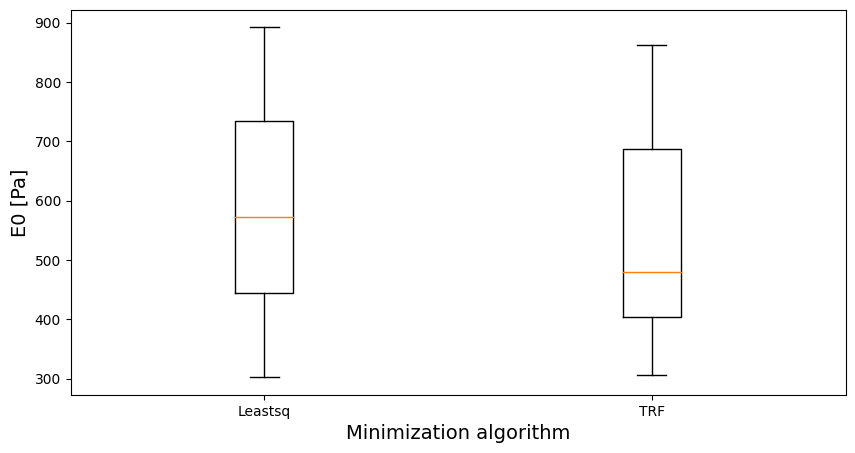

In [87]:
plt.boxplot([leastsq_results, trf_results], labels=["Leastsq", "TRF"])
plt.xlabel("Minimization algorithm", fontsize=14)
plt.ylabel("E0 [Pa]", fontsize=14)
plt.show()

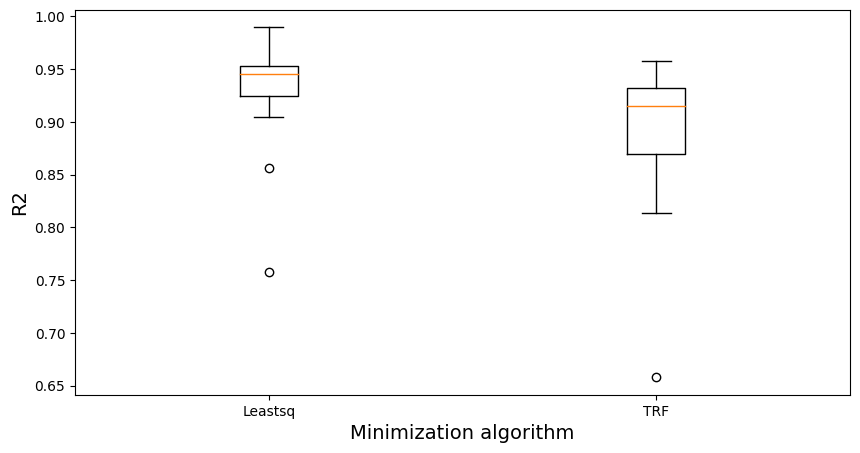

In [89]:
plt.boxplot([leastsq_results_r2, trf_results_r2], labels=["Leastsq", "TRF"])
plt.xlabel("Minimization algorithm", fontsize=14)
plt.ylabel("R2", fontsize=14)
plt.show()

25.572552423401703
39.34287631054326


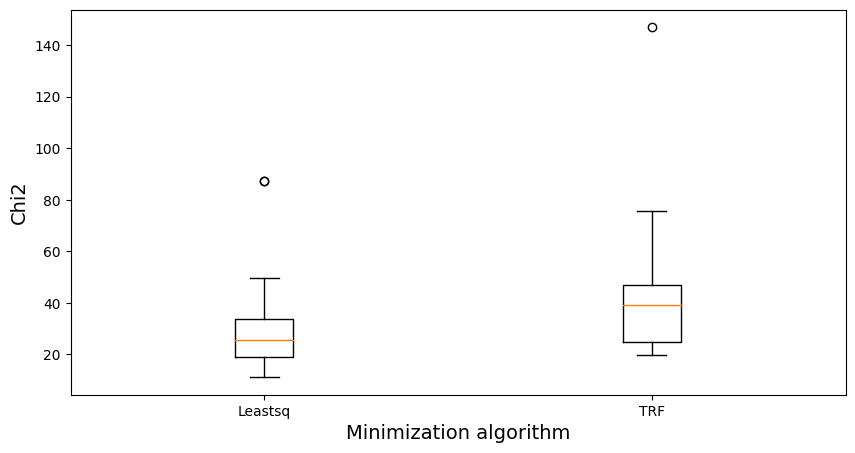

In [88]:
plt.boxplot([leastsq_results_chi2, trf_results_chi2], labels=["Leastsq", "TRF"])
print(np.median(leastsq_results_chi2))
print(np.median(trf_results_chi2))
plt.xlabel("Minimization algorithm", fontsize=14)
plt.ylabel("Chi2", fontsize=14)
plt.show()